In [2]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense
import tensorflow as tf
import numpy as np

In [3]:
# Download the dataset
mnist = tf.keras.datasets.mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
print(f"X_train.shape => {X_train.shape}")
print(f"X_test.shape => {X_test.shape}")
print(f"Y_train.shape => {Y_train.shape}")
print(f"Y_test.shape => {Y_test.shape}")

X_train.shape => (60000, 28, 28)
X_test.shape => (10000, 28, 28)
Y_train.shape => (60000,)
Y_test.shape => (10000,)


In [9]:
def build_encoder(input_shape, units_per_layer, dropout_rate):
    encoder_input = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Flatten()(encoder_input)
    for units in units_per_layer:
        x = tf.keras.layers.Dense(units, activation='relu')(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    encoder = tf.keras.Model(inputs=encoder_input, outputs=x, name='encoder')
    return encoder


def build_decoder(encoded_shape, units_per_layer, dropout_rate, output_shape):
    decoder_input = tf.keras.Input(shape=encoded_shape)
    x = decoder_input
    for units in reversed(units_per_layer):
        x = tf.keras.layers.Dense(units, activation='relu')(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.Dense(tf.math.reduce_prod(
        output_shape), activation='relu')(x)
    x = tf.keras.layers.Reshape(output_shape)(x)
    decoder = tf.keras.Model(inputs=decoder_input, outputs=x, name='decoder')
    return decoder

In [13]:
def train_model(model, X_train, epochs, batch_size):
    """
    Trains the given model on the provided data.

    Parameters:
    model: A TensorFlow/Keras model.
    X_train (np.array): Training data.
    epochs (int): Number of epochs to train the model.
    batch_size (int): Batch size for training.

    Returns:
    history: Training history object.
    """
    history = model.fit(X_train, X_train, epochs=epochs,
                        batch_size=batch_size, validation_split=0.2)
    return history


def train_model_with_early_stopping(model, X_train, epochs, batch_size, patience=5):
    """
    Trains the given model on the provided data with early stopping.

    Parameters:
    model: A TensorFlow/Keras model.
    X_train (np.array): Training data.
    epochs (int): Number of epochs to train the model.
    batch_size (int): Batch size for training.
    patience (int): Number of epochs to wait for improvement before stopping.

    Returns:
    history: Training history object.
    """
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=patience, restore_best_weights=True)

    history = model.fit(X_train, X_train, epochs=epochs, batch_size=batch_size,
                        validation_split=0.2, callbacks=[early_stopping])
    return history

In [6]:
def predict_model(model, X_test):
    """
    Generates predictions using the provided model.

    Parameters:
    model: A TensorFlow/Keras model.
    X_test (np.array): Data to generate predictions.

    Returns:
    predictions: Predicted output by the model.
    """
    predictions = model.predict(X_test)
    return predictions

In [7]:
import matplotlib.pyplot as plt


def plot_training_history(history):
    """
    Plots the training history of the model.

    Parameters:
    history: The history object returned from model training.
    """
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss During Training')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

In [10]:
# Define model parameters
input_shape = X_train.shape[1:]
encoder_units = [512, 256, 128]
decoder_units = [128, 256, 512]
dropout_rate = 0.2
output_shape = (28, 28)

# Build and compile the autoencoder
encoder = build_encoder(input_shape, encoder_units, dropout_rate)
decoder = build_decoder(
    encoder.output_shape[1:], decoder_units, dropout_rate, output_shape)

input_data = tf.keras.Input(shape=input_shape)
encoded_data = encoder(input_data)
decoded_output = decoder(encoded_data)

autoencoder = tf.keras.Model(
    inputs=input_data, outputs=decoded_output, name='autoencoder')
autoencoder.compile(
    loss='mae', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

# Display the summary with nested layers
autoencoder.summary(expand_nested=True)

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 encoder (Functional)        (None, 128)               566144    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_4 (InputLayer)       [(None, 28, 28)]          0        |
|                                                               |
| flatten_1 (Flatten)        (None, 784)               0        |
|                                                               |
| dense_7 (Dense)            (None, 512)               401920   |
|                                                               |
| dropout_6 (Dropout)        (None, 512)               0        |
|                                                               |
| dense_8 (Dense)            (None, 256)               

Epoch 1/50

375/375 [==============================] - 5s 10ms/step - loss: 0.1086 - val_loss: 0.0838
Epoch 2/50
375/375 [==============================] - 4s 11ms/step - loss: 0.0830 - val_loss: 0.0722
Epoch 3/50
375/375 [==============================] - 4s 12ms/step - loss: 0.0765 - val_loss: 0.0656
Epoch 4/50
375/375 [==============================] - 4s 11ms/step - loss: 0.0726 - val_loss: 0.0631
Epoch 5/50
375/375 [==============================] - 5s 13ms/step - loss: 0.0699 - val_loss: 0.0599
Epoch 6/50
375/375 [==============================] - 5s 14ms/step - loss: 0.0680 - val_loss: 0.0573
Epoch 7/50
375/375 [==============================] - 4s 12ms/step - loss: 0.0668 - val_loss: 0.0560
Epoch 8/50
375/375 [==============================] - 5s 12ms/step - loss: 0.0656 - val_loss: 0.0552
Epoch 9/50
375/375 [==============================] - 4s 11ms/step - loss: 0.0648 - val_loss: 0.0543
Epoch 10/50
375/375 [==============================] - 5s 12ms/step - loss: 0.0639 - val_l

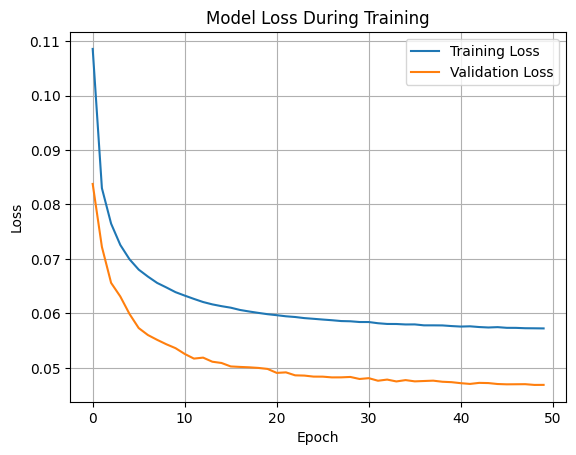

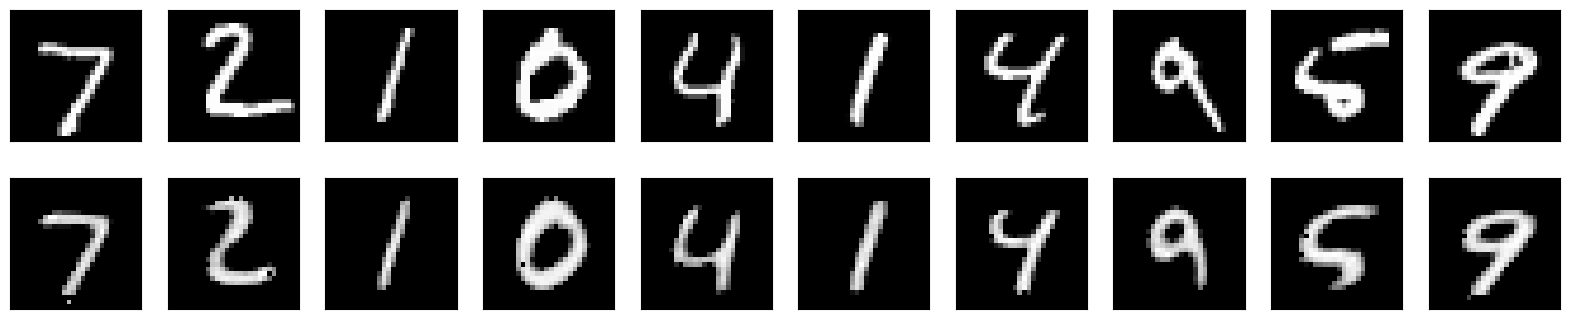

In [8]:
# Assuming X_train is your training data and X_test is your testing data

# Train the model
history = train_model(autoencoder, X_train, epochs=50, batch_size=128)

# Predict using the model
predictions = predict_model(autoencoder, X_test)

# Plot the training history
plot_training_history(history)

# Optionally, you can visualize the original and reconstructed images
n = 10  # Number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(predictions[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [11]:
# Define model parameters
input_shape = X_train.shape[1:]
encoder_units = [512, 256, 128, 64]
decoder_units = [64, 128, 256, 512]
dropout_rate = 0.2
output_shape = (28, 28)

# Build and compile the autoencoder
encoder = build_encoder(input_shape, encoder_units, dropout_rate)
decoder = build_decoder(
    encoder.output_shape[1:], decoder_units, dropout_rate, output_shape)

input_data = tf.keras.Input(shape=input_shape)
encoded_data = encoder(input_data)
decoded_output = decoder(encoded_data)

autoencoder = tf.keras.Model(
    inputs=input_data, outputs=decoded_output, name='autoencoder')
autoencoder.compile(
    loss='mae', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

# Display the summary with nested layers
autoencoder.summary(expand_nested=True)

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 encoder (Functional)        (None, 64)                574400    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_7 (InputLayer)       [(None, 28, 28)]          0        |
|                                                               |
| flatten_2 (Flatten)        (None, 784)               0        |
|                                                               |
| dense_14 (Dense)           (None, 512)               401920   |
|                                                               |
| dropout_12 (Dropout)       (None, 512)               0        |
|                                                               |
| dense_15 (Dense)           (None, 256)               

Epoch 1/50
375/375 [==============================] - 5s 9ms/step - loss: 0.1191 - val_loss: 0.1109
Epoch 2/50
375/375 [==============================] - 4s 10ms/step - loss: 0.1029 - val_loss: 0.0926
Epoch 3/50
375/375 [==============================] - 4s 10ms/step - loss: 0.0918 - val_loss: 0.0825
Epoch 4/50
375/375 [==============================] - 4s 10ms/step - loss: 0.0869 - val_loss: 0.0777
Epoch 5/50
375/375 [==============================] - 3s 9ms/step - loss: 0.0840 - val_loss: 0.0752
Epoch 6/50
375/375 [==============================] - 3s 9ms/step - loss: 0.0821 - val_loss: 0.0742
Epoch 7/50
375/375 [==============================] - 4s 10ms/step - loss: 0.0807 - val_loss: 0.0718
Epoch 8/50
375/375 [==============================] - 4s 10ms/step - loss: 0.0797 - val_loss: 0.0709
Epoch 9/50
375/375 [==============================] - 4s 9ms/step - loss: 0.0787 - val_loss: 0.0694
Epoch 10/50
375/375 [==============================] - 4s 10ms/step - loss: 0.0778 - val_loss: 

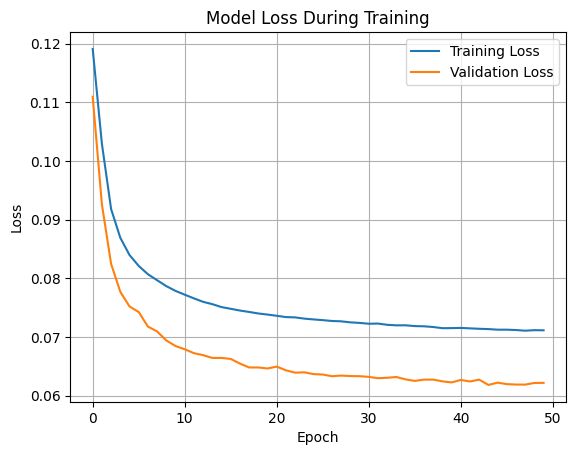

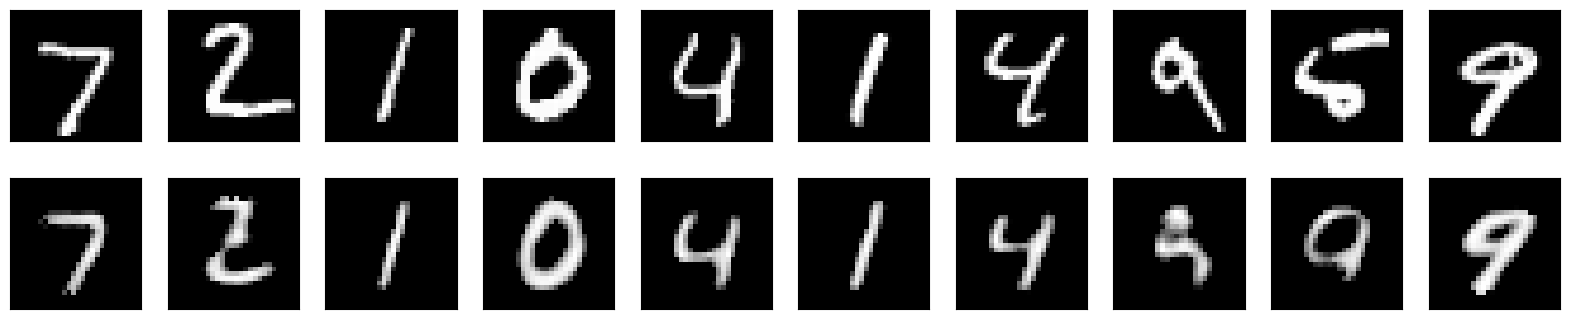

In [14]:
# Train the model with early stopping
history = train_model_with_early_stopping(autoencoder, X_train, epochs=50, batch_size=128, patience=10)

# Train the model
predictions = predict_model(autoencoder, X_test)

# Plot the training history
plot_training_history(history)

# Optionally, you can visualize the original and reconstructed images
n = 10  # Number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(predictions[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [15]:
# Define model parameters
input_shape = X_train.shape[1:]
encoder_units = [512, 256, 128, 64, 32]
decoder_units = [32, 64, 128, 256, 512]
dropout_rate = 0.2
output_shape = (28, 28)

# Build and compile the autoencoder
encoder = build_encoder(input_shape, encoder_units, dropout_rate)
decoder = build_decoder(
    encoder.output_shape[1:], decoder_units, dropout_rate, output_shape)

input_data = tf.keras.Input(shape=input_shape)
encoded_data = encoder(input_data)
decoded_output = decoder(encoded_data)

autoencoder = tf.keras.Model(
    inputs=input_data, outputs=decoded_output, name='autoencoder')
autoencoder.compile(
    loss='mae', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

# Display the summary with nested layers
autoencoder.summary(expand_nested=True)

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 encoder (Functional)        (None, 32)                576480    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_10 (InputLayer)      [(None, 28, 28)]          0        |
|                                                               |
| flatten_3 (Flatten)        (None, 784)               0        |
|                                                               |
| dense_23 (Dense)           (None, 512)               401920   |
|                                                               |
| dropout_20 (Dropout)       (None, 512)               0        |
|                                                               |
| dense_24 (Dense)           (None, 256)               

Epoch 1/50
375/375 [==============================] - 6s 11ms/step - loss: 0.1205 - val_loss: 0.1187
Epoch 2/50
375/375 [==============================] - 4s 11ms/step - loss: 0.1145 - val_loss: 0.1089
Epoch 3/50
375/375 [==============================] - 4s 11ms/step - loss: 0.1080 - val_loss: 0.1040
Epoch 4/50
375/375 [==============================] - 4s 11ms/step - loss: 0.1045 - val_loss: 0.1005
Epoch 5/50
375/375 [==============================] - 4s 11ms/step - loss: 0.1021 - val_loss: 0.0981
Epoch 6/50
375/375 [==============================] - 4s 11ms/step - loss: 0.1002 - val_loss: 0.0951
Epoch 7/50
375/375 [==============================] - 4s 12ms/step - loss: 0.0984 - val_loss: 0.0935
Epoch 8/50
375/375 [==============================] - 6s 17ms/step - loss: 0.0970 - val_loss: 0.0915
Epoch 9/50
375/375 [==============================] - 5s 14ms/step - loss: 0.0959 - val_loss: 0.0904
Epoch 10/50
375/375 [==============================] - 5s 13ms/step - loss: 0.0950 - val_lo

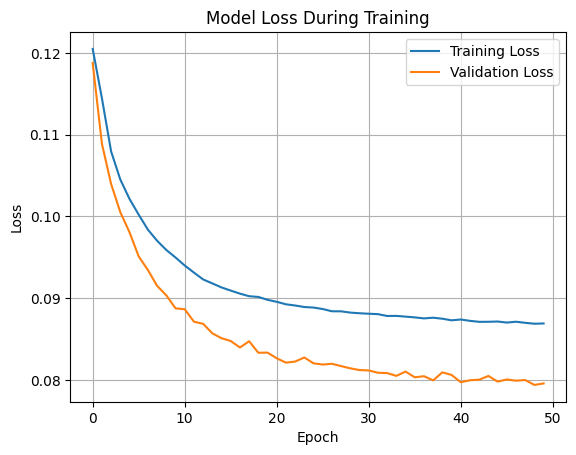

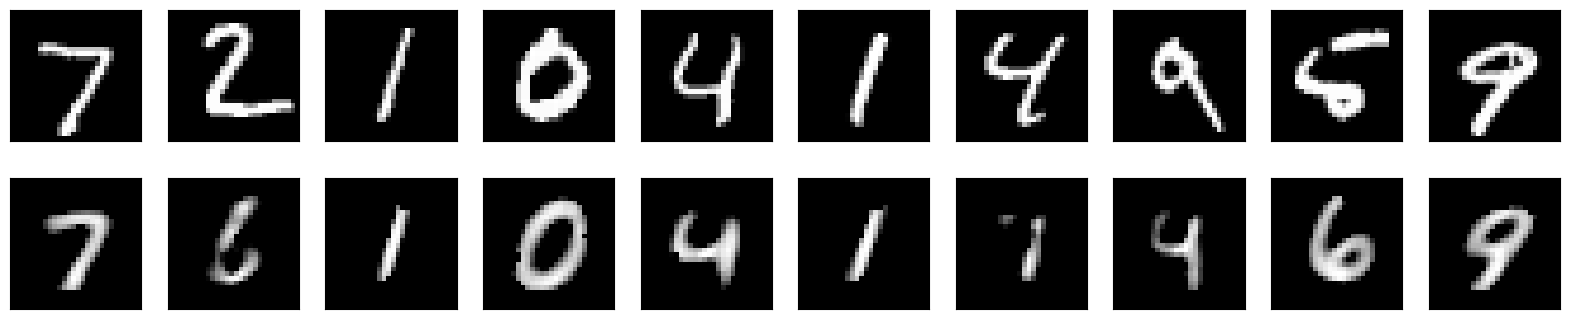

In [16]:
# Train the model with early stopping
history = train_model_with_early_stopping(autoencoder, X_train, epochs=50, batch_size=128, patience=10)

# Train the model
predictions = predict_model(autoencoder, X_test)

# Plot the training history
plot_training_history(history)

# Optionally, you can visualize the original and reconstructed images
n = 10  # Number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(predictions[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()